In [2]:
import os
import sys
import pickle
import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import torch
import pickle
from sklearn.preprocessing import LabelEncoder
from torch.optim import optimizer
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from torch.nn import CrossEntropyLoss,BCEWithLogitsLoss
from tqdm import tqdm_notebook, trange
!pip install pytorch_pretrained_bert
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM, BertForSequenceClassification
from pytorch_pretrained_bert.optimization import BertAdam, WarmupLinearSchedule
from sklearn.metrics import precision_recall_curve,classification_report
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import files
import numpy as np

from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/colab_data'

     |████████████████████████████████| 123 kB 5.4 MB/s 
     |████████████████████████████████| 131 kB 45.1 MB/s 
     |████████████████████████████████| 79 kB 7.4 MB/s 
     |████████████████████████████████| 8.1 MB 37.4 MB/s 
     |████████████████████████████████| 138 kB 36.4 MB/s 
     |████████████████████████████████| 127 kB 47.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Mounted at /content/drive


Reference:

https://zhuanlan.zhihu.com/p/72448986

https://zhuanlan.zhihu.com/p/145192287

https://blog.csdn.net/weixin_38235865/article/details/113618039

In [3]:
data = pd.read_csv(os.path.join(path, "weibo_sample_4mood.csv"))
data.columns = ['label','text']
data = data[['text','label']]
data.sample(3,random_state=1)

,text,label
9953,。胔 igh 啊。。。然后我被阿紫追问【您是有安装着怪逼搜索雷达摸】。。。,2
3850,明天参加老爷子的遗体告别仪式。只希望所有人都坚强！,2
4962,过了过了~ (投稿),0


In [3]:
le = LabelEncoder()
le.fit(data.label.tolist())
data['label'] = le.transform(data.label.tolist())
data.sample(3,random_state=1)

,text,label
9953,。胔 igh 啊。。。然后我被阿紫追问【您是有安装着怪逼搜索雷达摸】。。。,2
3850,明天参加老爷子的遗体告别仪式。只希望所有人都坚强！,2
4962,过了过了~ (投稿),0


In [10]:
# 分词工具
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-chinese', do_lower_case=False)

# 封装类
class DataPrecessForSingleSentence(object):
    """
    对文本进行处理
    """

    def __init__(self, bert_tokenizer, max_workers=10):
        """
        bert_tokenizer :分词器
        dataset        :包含列名为'text'与'label'的pandas dataframe
        """
        self.bert_tokenizer = bert_tokenizer
        # 创建多线程池
        self.pool = ThreadPoolExecutor(max_workers=max_workers)
        # 获取文本与标签

    def get_input(self, dataset, max_seq_len=30):
        """
        通过多线程（因为notebook中多进程使用存在一些问题）的方式对输入文本进行分词、ID化、截断、填充等流程得到最终的可用于模型输入的序列。
        
        入参:
            dataset     : pandas的dataframe格式，包含两列，第一列为文本，第二列为标签。标签取值为{0,1}，其中0表示负样本，1代表正样本。
            max_seq_len : 目标序列长度，该值需要预先对文本长度进行分别得到，可以设置为小于等于512（BERT的最长文本序列长度为512）的整数。
        
        出参:
            seq         : 在入参seq的头尾分别拼接了'CLS'与'SEP'符号，如果长度仍小于max_seq_len，则使用0在尾部进行了填充。
            seq_mask    : 只包含0、1且长度等于seq的序列，用于表征seq中的符号是否是有意义的，如果seq序列对应位上为填充符号，
                          那么取值为1，否则为0。
            seq_segment : shape等于seq，因为是单句，所以取值都为0。
            labels      : 标签取值为{0,1}，其中0表示负样本，1代表正样本。
        
            
        """
        sentences = dataset.iloc[:, 0].tolist()
        labels = dataset.iloc[:, 1].tolist()
        # 切词
        tokens_seq = list(
            self.pool.map(self.bert_tokenizer.tokenize, sentences))
        # 获取定长序列及其mask
        result = list(
            self.pool.map(self.trunate_and_pad, tokens_seq,
                          [max_seq_len] * len(tokens_seq)))
        seqs = [i[0] for i in result]
        seq_masks = [i[1] for i in result]
        seq_segments = [i[2] for i in result]
        return seqs, seq_masks, seq_segments, labels

    def trunate_and_pad(self, seq, max_seq_len):
        """
        1. 因为本类处理的是单句序列，按照BERT中的序列处理方式，需要在输入序列头尾分别拼接特殊字符'CLS'与'SEP'，
           因此不包含两个特殊字符的序列长度应该小于等于max_seq_len-2，如果序列长度大于该值需要那么进行截断。
        2. 对输入的序列 最终形成['CLS',seq,'SEP']的序列，该序列的长度如果小于max_seq_len，那么使用0进行填充。
        
        入参: 
            seq         : 输入序列，在本处其为单个句子。
            max_seq_len : 拼接'CLS'与'SEP'这两个特殊字符后的序列长度
        
        出参:
            seq         : 在入参seq的头尾分别拼接了'CLS'与'SEP'符号，如果长度仍小于max_seq_len，则使用0在尾部进行了填充。
            seq_mask    : 只包含0、1且长度等于seq的序列，用于表征seq中的符号是否是有意义的，如果seq序列对应位上为填充符号，
                          那么取值为1，否则为0。
            seq_segment : shape等于seq，因为是单句，所以取值都为0。
           
        """
        # 对超长序列进行截断
        if len(seq) > (max_seq_len - 2):
            seq = seq[0:(max_seq_len - 2)]
        # 分别在首尾拼接特殊符号
        seq = ['[CLS]'] + seq + ['[SEP]']
        # ID化
        seq = self.bert_tokenizer.convert_tokens_to_ids(seq)
        # 根据max_seq_len与seq的长度产生填充序列
        padding = [0] * (max_seq_len - len(seq))
        # 创建seq_mask
        seq_mask = [1] * len(seq) + padding
        # 创建seq_segment
        seq_segment = [0] * len(seq) + padding
        # 对seq拼接填充序列 
        seq += padding
        assert len(seq) == max_seq_len
        assert len(seq_mask) == max_seq_len
        assert len(seq_segment) == max_seq_len
        return seq, seq_mask, seq_segment

The pre-trained model you are loading is an uncased model but you have set `do_lower_case` to False. We are setting `do_lower_case=True` for you but you may want to check this behavior.
100%|██████████| 109540/109540 [00:00<00:00, 1407485.43B/s]


In [11]:
# 类初始化
processor = DataPrecessForSingleSentence(bert_tokenizer= bert_tokenizer)
# 产生输入ju 数据
seqs, seq_masks, seq_segments, labels = processor.get_input(
    dataset=data
    , max_seq_len=30)

In [15]:
# 加载预训练的bert模型
model = BertForSequenceClassification.from_pretrained(
    'bert-base-chinese', num_labels=4)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [7]:
# 转换为torch tensor
t_seqs = torch.tensor(seqs, dtype=torch.long)
t_seq_masks = torch.tensor(seq_masks, dtype = torch.long)
t_seq_segments = torch.tensor(seq_segments, dtype = torch.long)
t_labels = torch.tensor(labels, dtype = torch.long)

train_data = TensorDataset(t_seqs, t_seq_masks, t_seq_segments, t_labels)
train_sampler = RandomSampler(train_data)
train_dataloder = DataLoader(dataset= train_data, sampler= train_sampler,batch_size = 256)

In [13]:
# 将模型转换为trin mode
model.train()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [9]:
from torch import nn
class BertPooler(nn.Module):
    def __init__(self, config):
        super(BertPooler, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = nn.Tanh()

    def forward(self, hidden_states):
        # We "pool" the model by simply taking the hidden state corresponding
        # to the first token.
        first_token_tensor = hidden_states[:, 0]
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output

In [19]:
# 待优化的参数
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']

optimizer_grouped_parameters = [
    {
        'params':
        [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay':
        0.01
    },
    {
        'params':
        [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        'weight_decay':
        0.0
    }
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-05,
                     warmup= 0.1 ,
                     t_total= 2000)

device = torch.device('cuda')  #gpu版本
model = model.to(device)

In [21]:
# 存储每一个batch的loss
loss_collect = []
for i in trange(10, desc='Epoch'):
    for step, batch_data in enumerate(
            tqdm_notebook(train_dataloder, desc='Iteration')):
        batch_data = tuple(t.to(device) for t in batch_data)
        batch_seqs, batch_seq_masks, batch_seq_segments, batch_labels = batch_data
        # 对标签进行onehot编码
        one_hot = torch.zeros(batch_labels.size(0), 4).long().cuda()
        one_hot_batch_labels = one_hot.scatter_(
            dim=1,
            index=torch.unsqueeze(batch_labels, dim=1),
            src=torch.ones(batch_labels.size(0), 4).long().cuda())

        logits = model(
            batch_seqs, batch_seq_masks, batch_seq_segments, labels=None)
        logits = logits.softmax(dim=1)
        loss_function = CrossEntropyLoss()
        loss = loss_function(logits, batch_labels)
        loss.backward()
        loss_collect.append(loss.item())
        print("\r%f" % loss, end='')
        optimizer.step()
        optimizer.zero_grad()

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

1.410409

/usr/local/lib/python3.7/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1025.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


1.221151

Epoch:  10%|█         | 1/10 [01:52<16:53, 112.57s/it]

1.197386

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

1.232471

Epoch:  20%|██        | 2/10 [03:44<14:56, 112.09s/it]

1.119797

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

1.201072

Epoch:  30%|███       | 3/10 [05:36<13:04, 112.01s/it]

1.181436

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

1.169741

Epoch:  40%|████      | 4/10 [07:27<11:11, 111.88s/it]

1.554849

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

1.189201

Epoch:  50%|█████     | 5/10 [09:19<09:19, 111.87s/it]

1.181456

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

1.173818

Epoch:  60%|██████    | 6/10 [11:11<07:27, 111.86s/it]

1.055703

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

1.156340

Epoch:  70%|███████   | 7/10 [13:03<05:35, 111.86s/it]

1.304829

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

1.149470

Epoch:  80%|████████  | 8/10 [14:55<03:43, 111.87s/it]

1.227187

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

1.114508

Epoch:  90%|█████████ | 9/10 [16:47<01:51, 111.93s/it]

1.204706

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

1.103541

Epoch: 100%|██████████| 10/10 [18:39<00:00, 111.93s/it]

1.099013

In [22]:
torch.save(model, open(os.path.join(path,"job_fine_tuned_bert.bin"), "wb"))

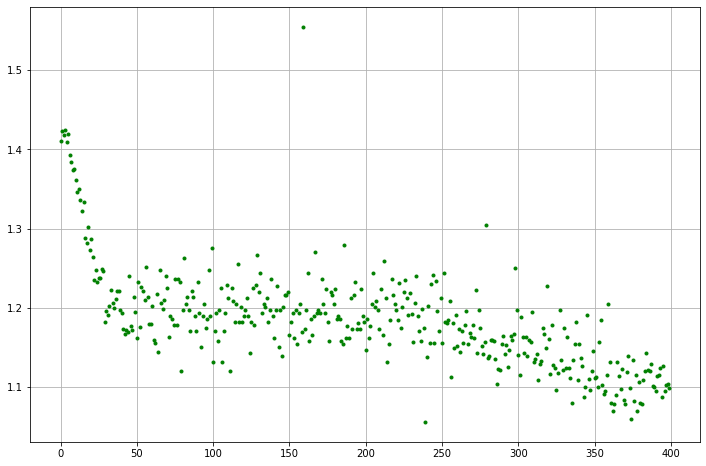

In [23]:
plt.figure(figsize=(12,8))
plt.plot(range(len(loss_collect)), loss_collect,'g.')
plt.grid(True)
plt.show()

In [24]:
test_data=data.sample(500, random_state = 1)
test_data

,text,label
9953,。胔 igh 啊。。。然后我被阿紫追问【您是有安装着怪逼搜索雷达摸】。。。,2
3850,明天参加老爷子的遗体告别仪式。只希望所有人都坚强！,2
4962,过了过了~ (投稿),0
3886,美国就喜欢当婊子立牌坊，中国牌坊都懒得立，直接赤果果的不要脸~ 人权社会以人为本“不论你是什...,2
5437,卫生部表示经专家组调查诊断后认定为预防接种异常反应的，对受种者给予一次性补偿。注意：不是紧急...,1
...,...,...
8361,A ，哇咔咔A A ==B ==悲催地发现，无论一开始我选王子还是卖花女，结果都是A C ....,0
7956,九月一日微波一跳,0
342,乜能野都拆晒(1你妄想！不偷工减料、添毒加废的害得你死剩半条命继续交税，你也得从南沙一路跪上...,2
2780,绝对白金珍藏版：灌篮高手十佳球【灌篮高手十佳球】绝对白金珍藏版。怎能一个“爽”字了得。。。,3


In [25]:
le = LabelEncoder()
le.fit(test_data.label.tolist())
test_data['label'] = le.transform(test_data.label.tolist())
# 转换为tensor
test_seqs, test_seq_masks, test_seq_segments, test_labels = processor.get_input(
    dataset=test_data, max_seq_len=30)
test_seqs = torch.tensor(test_seqs, dtype=torch.long)
test_seq_masks = torch.tensor(test_seq_masks, dtype = torch.long)
test_seq_segments = torch.tensor(test_seq_segments, dtype = torch.long)
test_labels = torch.tensor(test_labels, dtype = torch.long)
test_data = TensorDataset(test_seqs, test_seq_masks, test_seq_segments, test_labels)
test_dataloder = DataLoader(dataset= test_data, batch_size = 256)
# 用于存储预测标签与真实标签
true_labels = []
pred_labels = []
model = torch.load(open(os.path.join(path,"job_fine_tuned_bert.bin"), "rb"), map_location='cuda')
device = torch.device('cuda')  #gpu版本

model = model.to(device)

model.eval()
# 预测


with torch.no_grad():
    for batch_data in tqdm_notebook(test_dataloder, desc = 'TEST'):
        batch_data = tuple(t.to(device) for t in batch_data)
        batch_seqs, batch_seq_masks, batch_seq_segments, batch_labels = batch_data        
        logits = model(
            batch_seqs, batch_seq_masks, batch_seq_segments, labels=None)
        logits = logits.softmax(dim=1).argmax(dim = 1)
        pred_labels.append(logits.detach().cpu().numpy())
        true_labels.append(batch_labels.detach().cpu().numpy())

# 查看各个类别的准召
print(classification_report(np.concatenate(true_labels), np.concatenate(pred_labels)))       

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


TEST:   0%|          | 0/2 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.74      0.96      0.83       279
           1       0.55      0.32      0.41        68
           2       0.50      0.01      0.02        79
           3       0.41      0.53      0.46        74

    accuracy                           0.66       500
   macro avg       0.55      0.46      0.43       500
weighted avg       0.62      0.66      0.59       500



In [26]:
print(pred_labels)
print(true_labels)

[array([0, 3, 3, 0, 1, 0, 0, 0, 0, 3, 0, 0, 3, 1, 0, 0, 1, 0, 0, 0, 1, 3,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 3, 0, 3, 1,
       0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 3, 0, 0, 0, 3, 3, 0, 3, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0,
       0, 3, 0, 1, 0, 1, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
       0, 0, 0, 0, 0, 3, 0, 0, 3, 3, 3, 3, 0, 3, 0, 0, 1, 0, 0, 0, 3, 3,
       0, 0, 3, 0, 0, 1, 3, 0, 0, 0, 3, 3, 0, 0, 3, 1, 2, 0, 0, 3, 0, 0,
       0, 0, 0, 0, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 3, 3, 0, 0,
       3, 0, 1, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
       3, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 3, 0, 3, 0, 0, 3, 0, 0, 3,
       0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([3, 0, 1, 3, 0, 0, 0, 1, 3, 1, 0, 0, 0, 0, 3, 3, 3, 0, 0, 0, 0, 3,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0,